# Thesis Project

This is the software project for the bachelor thesis on "Modelling of Perturbations in Seismocardiography Signals". The complete source code is included in this notebook and contains the full processing pipeline, including the loading and pre-processing of the datasets, the training of the autoencoders, the evaluation for the four experiments and further utility functions to create visualisations of the results. The rest of the project is structured as follows: First, the necessary imports for the project are made, followed by the configuration of some important settings on which the rest of the project is based. Then the dataset(s) will be imported and pre-processed, followed by the definition and training of the autoencoders. Finally, the testing and evaluation for the four different experiments and their respective sub-experiments are specified, after which functions for the visualisation of the results are defined.

## Requirements and Imports

All requirements in this project are managed by `Pipenv` and are specified in the `Pipfile` which is located in the same directory as this notebook. This code cell imports all the packages required for this project, including some basic imports such as numpy, pandas, matplotlib or other basic Python packages, all imports related to PyTorch and RayTune, and finally all imports related to either scipy or scikit-learn.

In [1]:
# Basic imports
import os
import re
import glob
import wfdb
import time
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wfdb import processing
from functools import partial

# PyTorch-related imports
import torch
import torchinfo
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# RayTune-related imports
from ray import tune, put, get, ray
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

# Scipy and Sklearn-related imports
from scipy import signal, stats
from statsmodels.tsa.stattools import ccf
from skimage.restoration import denoise_wavelet
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Configuration

The following code cell can be used to configure certain general aspects of the project related to random number generation, graphics card utilisation, machine learning model and data loading, noise modelling and training. In particular, for the data loading settings, not only the directory from which the files are loaded is set, but also the sampling rate at which all the data is resampled, and settings for splitting the data with a given `window_size`, where the windows have an offset of a given `step_size`. To model the white Gaussian noise (WGN), the noise distributions for testing and training are specified here.

In [2]:
# Set a random seed for pytorch (always split the data the same way), for the random package and for numpy. Required for reproducibility of the experiments.
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# If a GPU (Cuda) is available, it will be used to train and test the machine learning models.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# The directory for saving and loading the trained autoencoder models.
model_directory = './models/'

# Here, some basic settings for the datasets and are set.
data_directory = './data/' # Where to load the datasets from. Should be the same directory as in the `init.sh` script.
sampling_rate = 100 # Hz # Resample the data to this sampling rate.
window_size = 512 # Of how many datapoints one sample should consist.
step_size = 64 # How many datapoints are between the different samples. Implemented with a rolling window.

train_prob = 0.8 # Relative size of the train set to complete dataset
val_prob = 0.2 # Relative size of the validation set to the train set

# The target noise SNR values for training and testing in dB.

# train_target_snrs = [-2.5, 0, 2.5] # WGN1
# train_target_snrs = [-2.5, 0, 2.5, 2.5, 5, 7.5] # WGN2
train_target_snrs = [-2.5, 0, 2.5, 7.5, 10, 12.5] # WGN3
# train_target_snrs = [-2.5, 0, 2.5, 17.5, 20, 22.5] # WGN4

test_target_snrs =  [-1, 0, 2, 5, 7] # WGN5
# test_target_snrs = [-1]
# test_target_snrs = [7]

# Number of epochs for training.
num_epochs = 64

## Dataset

The first code cell contains some functions for normalising and denormalising a one- or two-dimensional array, but also a Butterworth bandpass filter with a standard configuration of order four and cutoff frequencies of 5 and 30 Hz for SCG signals. In addition, a filter is implemented to remove peaks from a given signal by calculating the z-score of each value, where any datapoint with a value above a given threshold is set to the mean of the signal.

The second cell includes a utility class used to manage the data required for training and testing. It inherits from the PyTorch `Dataset` class, which provides tools such as splitting the data into training, validation and test subsets, or using it in dataloaders to efficiently access the data in minibatches during training and testing. The data for the experiments may consist the [CEBS](https://physionet.org/content/cebsdb/1.0.0/) dataset, the [IEEE](https://ieee-dataport.org/documents/mechanocardiograms-ecg-reference) dataset and/or another dataset called [ECMS](https://zenodo.org/record/5279448), as described in the thesis. Either clean SCG or clean ECG samples can be used as y-samples and SCG or noisy SCG samples as x-samples. 

The data from the specified datasets is loaded directly when an `SCGData` class object is initialised, depending on the specific configuration of that object, which is described below. Each dataset is imported according to its specific characteristics, the schemes are normalised, the dataset is resampled and each dataset is split into samples with a size of `window_size` and an offset of `step_size`. A fourth order Butterworth bandpass filter with cutoff frequencies of 5 and 30 Hz is also applied to the SCG samples, followed by a filter based on the calculation of the z-score of each datapoint to remove outliers with a threshold of 5 and a normalisation of the data between -1 and 1 per subject. All datasets are then combined. 

Initially, no noise is added to the data so that training and testing can be done with different noise levels. The noise generated is white Gaussian noise and/or a second noise model focussing on motion noise. The two noise models can be used independently or together, the latter with a certain probability of generating white Gaussian noise. The motion-focused noise model takes noise data from a dataset that includes [data from a chest-worn accelerometer](https://archive.ics.uci.edu/ml/datasets/Activity+Recognition+from+Single+Chest-Mounted+Accelerometer) during 7 different activities. The gravity component is removed from the motion data as it is already present in the SCG datasets and outliers are removed using the z-score method with a threshold of 5. To model the motion noise, `window_size` long random consecutive samples are extracted and 80% of their values are added to the clean SCG samples.

In [3]:
'''
A method to normalise the input data between -1 and 1. Returns the minimum and maximum values of the original signal as well for later denormalisation.
:param data: The data (array) that should be normalised.
'''
def normalise(data):
    # If the data consists of several arrays, concatenate them to find the minimum and maximum.
    data_concat = np.concatenate(data) if data[0].ndim == 1 else data
    min_val = np.min(data_concat)
    max_val = np.max(data_concat)
    data_norm = 2 * (data - min_val) / (max_val - min_val) - 1
    return data_norm, min_val, max_val

'''
Denormalises the input data to its original form, given the minimum and maximum values of the original signal.
:param data: The data that should be denormalised.
:param min_val: The minimum value of the original, not normalised data.
:param max_val: The maximum value of the original, not normalised data.
'''
def denormalise(data, min_val, max_val):
    data_denorm = (max_val * data + max_val - data * min_val + min_val) / 2
    return data_denorm

'''
A Butterworth bandpass filter for the input signal.
:param input_signal: The signal to which the filter should be applied to.
:param order: The order of the filter.
:param fs: The frequency space.
:param lowcut: The highcut of the filter.
:param highcut: The lowcut of the filter.
'''
def bandpass(input_signal, order=4, fs=100.0, lowcut=5.0, highcut=30.0):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    b, a, = signal.butter(order, [low, high], 'bandpass', analog=False)
    y = signal.filtfilt(b, a, input_signal, axis=0)

    return y

'''
A method to filter out peaks of a given input signal by comparing the z-score of each datapoint to a threshold value. 
:param input_signal: The signal to which the filter should be applied to.
:param z_score_th: Every datapoint with a z-score above this threshold will be set to the mean of the signal.
'''
def filter_peaks(input_signal, z_score_th=7):
    output_signal = input_signal.copy()
    output_signal.loc[np.abs(stats.zscore(output_signal)) > z_score_th] = output_signal.mean()
    return output_signal

In [4]:
class SCGData(Dataset):

    '''
    A dataset class to manage all the different datasets being used in this project.

    :param directory: The directory where the datasets (each in its own directory) are located.
    :param datasets: A list of strings from ['CEBS', 'ECMS', 'IEEE'] of the datasets that should be loaded.
    :param sampling_rate: The sampling rate at which the data from all datasets will be resampled per subject.
    :param window_size: The size of the windows into which the data is divided per subject.
    :param step_size: The number of datapoints between the respective windows. Implemented as a rolling window.
    :param transform: The transformation that will be applied to the data samples when they are accessed.
    :param ecg: If true, the y_data will be ECG data and otherwise the clean SCG data.
    :param noise: If true, noise may be added to self.scg_clean by calling the add_noise method. Ultimately, this will be the x_data. 
                  Otherwise, calling this method will have no effects.
    :param remove_cebs: A list of strings containing the filenames of the CEBS dataset that should be omitted. None, if no files should be omitted.
    :param leave_cebs: A list of strings containing the filenames of the CEBS dataset that should be included. All other files will be omitted. 
                       None if all files should be included.
    '''
    def __init__(self, directory, datasets, sampling_rate, window_size, step_size, transform=None, ecg=False, noise=True, remove_cebs=None, leave_cebs=None):

        self.directory = directory
        self.datasets = datasets

        self.sampling_rate = sampling_rate
        self.window_size = window_size
        self.step_size = step_size
        
        self.transform = transform
        
        self.ecg = ecg
        self.noise = noise
        self.leave_cebs = leave_cebs
        self.remove_cebs = remove_cebs

        self.data_motion_noise = None # Saves the data loaded from the motion dataset to add motion noise later.
        
        # The min/max values after normalising the noise noisy x_data. Used for later denormalisation to calculate the SNR.
        self.min_val = None
        self.max_val = None

        # Load the motion noise data.
        self._load_motion_noise_data()

        # Load and pre-process the requested datasets from `self.datasets`.
        data = self._load_datasets()
        
        # Clean SCG data to add noise to it later in order to create the possibly noisy x_data.
        self.scg_clean = data.SCG.to_numpy(copy=True)
        
        # The y values are either ECG samples (when ecg=True) or SCG samples (when ecg=False). Noise will be added later to the x_data.
        self.x_data = data.SCG.to_numpy()
        self.y_data = data.ECG.to_numpy() if self.ecg else data.SCG.to_numpy()

        self.n_samples = data.shape[0]

    '''
    The function may be called to add noise to the x_data when self.noise is True.

    :param target_snrs: A list of SNRs to be added with the WGN model. 
    :param noise_model: This parameter can either be 'WGN' for the White Gaussian Noise, 'MOTION' for the motion-based noise model or 'BOTH' for both noise models to be added to the dataset.
    :param wgn_prob: Specifies the probability that the WGN model will be added to the dataset when 'BOTH' is selected as the noise model.
    :param use_bandpass: If true, a bandpass filter is applied to the noisy data after adding noise within the add_noise method.
    '''
    def add_noise(self, target_snrs, noise_model='WGN', wgn_prob=0.4, use_bandpass=False):

        if self.noise:
            if noise_model == 'WGN':
                data_noise = np.array([self._add_gaussian(inputs, target_snrs) for inputs in self.scg_clean])
            elif noise_model == 'MOTION':
                data_noise = np.array([self._add_motion(inputs) for inputs in self.scg_clean])
            elif noise_model == 'BOTH':
                data_noise = np.array([self._add_gaussian(inputs, target_snrs) if random.random() < wgn_prob else self._add_motion(inputs) for inputs in self.scg_clean])

            self.x_data, self.min_val, self.max_val = normalise(data_noise)

            if use_bandpass:
                self.x_data = np.array([bandpass(inputs, order=4, fs=100.0, lowcut=5.0, highcut=30.0) for inputs in self.x_data])

    '''
    A function to add motion noise to its inputs.

    :param data: The data, to which the noise should be added.
    '''
    def _add_motion(self, data):
        
        # Randomly select `len(data)` consecutive datapoints from the processed noise dataset.
        len_sample = len(data)
        rows = range(self.data_motion_noise.shape[0])
        index_start = random.randint(rows.start, rows.stop - len_sample)
        noise = self.data_motion_noise.iloc[index_start:index_start + len_sample]
        
        # Only add 80 % of noise to the data.
        return data + 0.8 * noise

    '''
    A function to add WGN to its input with specific SNRs.

    :param data: The data to which the noise should be added.
    :param target_snrs: A list of SNRs to be added. 
    '''
    def _add_gaussian(self, data, target_snrs):

        target_snr = random.choice(target_snrs)

        data_watts_mean = np.mean(data ** 2)
        data_db_mean = 10 * np.log10(data_watts_mean)

        noise_db_mean = data_db_mean - target_snr
        noise_watts_mean = 10 ** (noise_db_mean / 10)

        mean_noise = 0
        noise = np.random.normal(mean_noise, np.sqrt(noise_watts_mean), len(data))
        
        return data + noise

    '''
    Loads the motion noise dataset, upsamples, filters and normalises it.
    '''
    def _load_motion_noise_data(self):
        
        data = pd.DataFrame()

        # Load the data from the 16 files
        for i in range(1, 16):
            rel_path = os.path.join('NOISE_ACC', f'{i}.csv')
            df = pd.read_csv(os.path.join(self.directory, rel_path), header=None, usecols=[3, 4], names=['Z', 'labels'])
            
            df_resample = pd.DataFrame()
            frequency = 52

            # Upsample the z-axis data, subtract the mean (gravity component), remove outliers and normalise it 
            df_resample['Z'] = processing.resample_sig(df['Z'], frequency, self.sampling_rate)[0]
            df_resample['Z'] = df_resample['Z'] - df_resample['Z'].mean() # Remove the gravity component from the acceleration data
            df_resample['Z'] = filter_peaks(df_resample['Z'], z_score_th=5)
            df_resample['Z'], _, _ = normalise(df_resample['Z'])

            # Upsample the labels, round them and prevent values larger than 7 and smaller than 1.
            df_resample['labels'] = processing.resample_sig(df['labels'], frequency, self.sampling_rate)[0]
            df_resample['labels'] = df_resample['labels'].round(decimals=0)
            df_resample.loc[df_resample['labels'] > 7, 'labels'] = 7
            df_resample.loc[df_resample['labels'] < 1, 'labels'] = 1

            data = pd.concat((data, df_resample))

        # The different activities in the dataset.
            # 1: Working at Computer
            # 2: Standing Up, Walking and Going up\down stairs
            # 3: Standing
            # 4: Walking
            # 5: Going Up\Down Stairs
            # 6: Walking and Talking with Someone
            # 7: Talking while Standing

        # Here it is possible to only allow certain activities in the noise dataset.
        self.data_motion_noise = data.loc[data['labels'] == 4, 'Z']
        # self.data_motion_noise = data['Z']

    
    '''
    Loads one file of the CEBS dataset and processes it. This includes resampling, filtering and splitting into groups of `self.window_size` long samples.

    :param filename: The name of the specific file to be loaded.
    '''
    def _load_cebs(self, filename):
        
        # Using WFDB to import the files.
        record = wfdb.rdsamp(filename)
        data = record[0]
        metadata = record[1]

        frequency = metadata['fs']
        column_names = metadata['sig_name']

        data = pd.DataFrame(data, columns=column_names)
        data.drop(['II', 'RESP'], axis=1, inplace=True)
        data.rename(columns={'I': 'ECG'}, inplace=True)

        # Resample the data into the desired sampling rate and use a bandpass filter on the SCG samples.
        scg = processing.resample_sig(data['SCG'], frequency, self.sampling_rate)[0]
        scg = bandpass(scg, order=4, fs=100.0, lowcut=5.0, highcut=30.0)
        ecg = processing.resample_sig(data['ECG'], frequency, self.sampling_rate)[0]

        data = pd.DataFrame({'SCG': scg, 'ECG': ecg})

        # Filter out outliers from the SCG data
        data['SCG'] = filter_peaks(data['SCG'], z_score_th=7)

        # Split the data into groups with `self.window_size` and an offset of `self.step_size` datapoints.
        data = pd.DataFrame([[x.ECG.to_numpy(), x.SCG.to_numpy()] for x in data.rolling(window=self.window_size, step=self.step_size) if x.shape[0] == self.window_size])
        data.columns = ['ECG', 'SCG']

        # Normalise the ECG and/or SCG data
        # data['ECG'], _, _ = normalise(data['ECG'])
        data['SCG'], _, _ = normalise(data['SCG'])
        
        return data


    '''
    Loads one file of the ECMS dataset and processes it. This includes resampling, filtering and splitting into groups of `self.window_size` long samples.

    :param filename: The name of the specific file to be loaded.
    '''
    def _load_ecms(self, filename):

        # Since the files are not structured the same, they have to be imported differently. The following code does that.
        # Regex to identify files with specific names, as they are structured differently.
        regex_up_1 = re.compile(r'./data/ECMS/UP-(((0|1)[0-9])|(20|21))-*') # Files named 'UP-[01-21]-Raw.csv'
        regex_up_2 = re.compile(r'./data/ECMS/UP-(22|23)-*') # Files named 'UP-[22-23]-Raw.csv'

        # Import the file depending on its structure.
        if re.match(r'./data/ECMS/CP-*', filename):
            data = pd.read_csv(filename, 
                    sep=',', 
                    header=1, 
                    skiprows=[2],
                    usecols=['Shimmer_D0CD_ECG_LA-RA_24BIT_CAL', 'Shimmer_D0CD_Accel_LN_Z_CAL'], 
                    dtype={'Shimmer_D0CD_ECG_LA-RA_24BIT_CAL': 'float', 'Shimmer_D0CD_Accel_LN_Z_CAL': 'float'})
            data.rename(columns={'Shimmer_D0CD_ECG_LA-RA_24BIT_CAL': 'ECG', 'Shimmer_D0CD_Accel_LN_Z_CAL': 'SCG'}, inplace=True)
            frequency = 256
        elif regex_up_1.match(filename):
            data = pd.read_csv(filename, 
                    sep='	', 
                    header=1, 
                    skiprows=[2],
                    usecols=['ECG_ECG_LA-RA_24BIT_CAL', 'ECG_Accel_LN_Z_CAL'], 
                    dtype={'ECG_ECG_LA-RA_24BIT_CAL': 'float', 'ECG_Accel_LN_Z_CAL': 'float'})
            data.rename(columns={'ECG_ECG_LA-RA_24BIT_CAL': 'ECG', 'ECG_Accel_LN_Z_CAL': 'SCG'}, inplace=True)
            frequency = 256
        elif regex_up_2.match(filename):
            data = pd.read_csv(filename, 
                    sep=',', 
                    header=1, 
                    skiprows=[2],
                    usecols=['ECG_ECG_LA-RA_24BIT_CAL', 'ECG_Accel_LN_Z_CAL'], 
                    dtype={'ECG_ECG_LA-RA_24BIT_CAL': 'float', 'ECG_Accel_LN_Z_CAL': 'float'})
            data.rename(columns={'ECG_ECG_LA-RA_24BIT_CAL': 'ECG', 'ECG_Accel_LN_Z_CAL': 'SCG'}, inplace=True)
            frequency = 512
        elif re.match(r'./data/ECMS/UP-*', filename):
            data = pd.read_csv(filename, 
                    sep=',', 
                    header=0, 
                    skiprows=[1],
                    usecols=['ECG_ECG_LA-RA_24BIT_CAL', 'ECG_Accel_LN_Z_CAL'], 
                    dtype={'ECG_ECG_LA-RA_24BIT_CAL': 'float', 'ECG_Accel_LN_Z_CAL': 'float'})
            data.rename(columns={'ECG_ECG_LA-RA_24BIT_CAL': 'ECG', 'ECG_Accel_LN_Z_CAL': 'SCG'}, inplace=True)            
            frequency = 512
        else:
            return pd.DataFrame()

        # Resample the data into the desired sampling rate and apply a bandpass filter to the SCG samples.
        scg = processing.resample_sig(data['SCG'], frequency, self.sampling_rate)[0]
        scg = bandpass(scg, order=4, fs=100.0, lowcut=5.0, highcut=30.0)
        ecg = processing.resample_sig(data['ECG'], frequency, self.sampling_rate)[0]
        # ecg = bandpass(ecg, order=4, fs=100.0, lowcut=8.0, highcut=20.0)

        data = pd.DataFrame({'SCG': scg, 'ECG': ecg})
        
        # Filter out the outliers from the SCG data
        data['SCG'] = filter_peaks(data['SCG'], z_score_th=7)
        # data['ECG'] = filter_peaks(data['ECG'], z_score_th=7)

        # Split the data into groups with `self.window_size` and an offset of `self.step_size` datapoints.
        data = pd.DataFrame([[x.ECG.to_numpy(), x.SCG.to_numpy()] for x in data.rolling(window=self.window_size, step=self.step_size) if x.shape[0] == self.window_size])
        data.columns = ['ECG', 'SCG']

        # Normalise the ECG and/or SCG data
        data['SCG'], _, _ = normalise(data['SCG'])
        # data['ECG'], _, _ = normalise(data['ECG'])

        return data

    
    '''
    Loads one file of the IEEE dataset and processes it. This includes resampling, filtering and splitting into groups of `self.window_size` long samples.

    :param filename: The name of the specific file to be loaded.
    '''
    def _load_ieee(self, filename):
        
        # Because of different headers in the files, a varying amount of rows has to be skipped.
        if any(str(num) in filename for num in range(10,30)):
            skiprows = 19
        elif any(str(num) in filename for num in [8, 9]):
            skiprows = 17
        elif any(str(num) in filename for num in [2, 4, 5, 6, 7, 8]):
            skiprows = 16
        else:
            skiprows = 15

        data = pd.read_csv(filename, sep=' ', header=None, skiprows=skiprows, usecols=[0,3], names=['ECG', 'SCG'], dtype={'ECG': 'float', 'SCG': 'float'})
        frequency = 800

        # Resample the data into the desired sampling rate and apply a bandpass filter to the SCG samples.
        scg = processing.resample_sig(data['SCG'], frequency, self.sampling_rate)[0]
        scg = bandpass(scg, order=4, fs=100.0, lowcut=5.0, highcut=30.0)
        ecg = processing.resample_sig(data['ECG'], frequency, self.sampling_rate)[0]
        # ecg = bandpass(ecg, order=4, fs=100.0, lowcut=8.0, highcut=20.0)

        data = pd.DataFrame({'SCG': scg, 'ECG': ecg})
        
        # Filter out the outliers from the SCG data
        data['SCG'] = filter_peaks(data['SCG'], z_score_th=7)
        # data['ECG'] = filter_peaks(data['ECG'], z_score_th=7)

        # Split the data into groups with `self.window_size` and an offset of `self.step_size` datapoints.
        data = pd.DataFrame([[x.ECG.to_numpy(), x.SCG.to_numpy()] for x in data.rolling(window=self.window_size, step=self.step_size) if x.shape[0] == self.window_size])
        data.columns = ['ECG', 'SCG']
        
        # Normalise the ECG and.or SCG data
        data['SCG'], _, _ = normalise(data['SCG'])
        # data['ECG'], _, _ = normalise(data['ECG'])

        return data


    '''
    Loads the datasets specified in `self.datasets`.
    '''
    def _load_datasets(self):

        data = pd.DataFrame(dtype='object')

        # Loads the CEBS dataset from the 'CEBS' directory in the directory folder.
        if 'CEBS' in self.datasets:
            print('Loading CEBS')
            
            directory = os.path.join(self.directory, 'CEBS')
            if self.leave_cebs:
                # Only load the specified files in `self.leave_cebs` if it is set
                filenames = [os.path.join(directory, filename) for filename in self.leave_cebs]
            else:
                # Load all files otherwise
                filenames = list(dict.fromkeys([x[:-4] for x in glob.glob(f'{directory}/*[0-9][0-9][0-9].*')]))
            if self.remove_cebs:
                # Remove the files specified in `self.remove_cebs`, if any.
                for filename in self.remove_cebs:
                    filenames.remove(os.path.join(directory, filename))
            
            data_cebs = pd.concat((self._load_cebs(filename) for filename in filenames), ignore_index=True)
            data = pd.concat((data, data_cebs))
            print(f'\tLoaded {data_cebs.shape[0]} samples')

        # Loads the ECMS dataset from the 'ECMS' directory in the directory folder.
        if 'ECMS' in self.datasets:
            print('Loading ECMS')
            
            directory = os.path.join(self.directory, 'ECMS')
            filenames = glob.glob(f'{directory}/*')
            data_ecms = pd.concat((self._load_ecms(filename) for filename in filenames), ignore_index=True)
            data = pd.concat((data, data_ecms))
            print(f'\tLoaded {data_ecms.shape[0]} samples')

        # Loads the IEEE dataset from the 'IEEE' directory in the directory folder.
        if 'IEEE' in self.datasets:
            print('Loading IEEE')
            
            directory = os.path.join(self.directory, 'IEEE')
            filenames = glob.glob(f'{directory}/*')
            data_ieee = pd.concat((self._load_ieee(filename) for filename in filenames), ignore_index=True)
            data = pd.concat((data, data_ieee))
            print(f'\tLoaded {data_ieee.shape[0]} samples')
        
        print(f'\nLoaded {data.shape[0]} samples in total')

        return data

    '''
    Returns a sample with the specified index and applies the transformation, if it is set.

    :param index: The index of the sample to be returned.
    '''
    def __getitem__(self, index):
        sample = self.x_data[index].copy(), self.y_data[index].copy()

        if self.transform:
            sample = self.transform(sample)
        
        return sample
    
    '''
    Returns the length of the dataset.
    '''
    def __len__(self):
        return self.n_samples


class ToTensor:

    '''
    Transformation class used to transform numpy arrays to PyTorch tensors.

    :param sample: The sample from the dataset to be transformed.
    '''
    def __call__(self, sample):
        inputs, targets = sample
        return torch.from_numpy(inputs), torch.from_numpy(targets)

In [5]:
'''
Loads the data and returns randomly splitted train and test datasets with a predetermined train size. 
The parameters are equal to those used in the __init__ method of the SCGData class.
'''
def load_data(*args, **kwargs):
    dataset = SCGData(*args, **kwargs)
    train_size = int(train_prob * len(dataset))
    test_size = len(dataset) - train_size
    return torch.utils.data.random_split(dataset, [train_size, test_size])

In [6]:
# Imports the dataset and splits it into a train and test subset.
# ['b001', 'm001', 'p001', 'b002', 'm002', 'p002']
train_dataset, test_dataset = load_data(data_directory, ['CEBS'], sampling_rate, window_size, step_size, transform=ToTensor(), ecg=True, noise=False, remove_cebs=None, leave_cebs=None)

Loading CEBS
	Loaded 111514 samples

Loaded 111514 samples in total


## Machine Learning Models

The next two code cells implement 2 fully convolutional denoising autoencoders. 

The first one consists of 4 convolutional layers in the encoder and 4 transpose convolutional layers in the decoder plus another convolutional output layer in the decoder. Each convolutional layer is followed by a batch normalisation layer, and ELU is used as the activation function, with the hyperbolic tangent function used for the output layer. The kernel size is set to 7 with a stride of 1 while the number of kernels, `kernel_count`, is halved with each convolutional layer in the encoder and is doubled with each layer in the decoder. The last layer in the encoder and decoder but also the output layer have only one kernel. No padding is applied to any layer except the output layer, where padding is set to `same`.

The second autoencoder is nearly equivalent to the first one. However, the stride of the second last layer of the encoder and the second layer of the decoder are set to 2 while the output padding for those layers is set to 1.

In [7]:
class AE1(nn.Module):
    def __init__(self, kernel_count=128):
        super(AE1, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(1, int(kernel_count), 7, stride=1, padding=0),
            nn.BatchNorm1d(int(kernel_count)),
            nn.ELU(),
            nn.Conv1d(int(kernel_count), int(kernel_count/2), 7, stride=1, padding=0),
            nn.BatchNorm1d(int(kernel_count/2)),
            nn.ELU(),
            nn.Conv1d(int(kernel_count/2), int(kernel_count/4), 7, stride=1, padding=0),
            nn.BatchNorm1d(int(kernel_count/4)),
            nn.ELU(),
            nn.Conv1d(int(kernel_count/4), 1, 7, stride=1, padding=0),
            nn.BatchNorm1d(1),
            nn.ELU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(1, int(kernel_count/4), 7, stride=1, padding=0),
            nn.BatchNorm1d(int(kernel_count/4)),
            nn.ELU(),
            nn.ConvTranspose1d(int(kernel_count/4), int(kernel_count/2), 7, stride=1, padding=0),
            nn.BatchNorm1d(int(kernel_count/2)),
            nn.ELU(),
            nn.ConvTranspose1d(int(kernel_count/2), int(kernel_count), 7, stride=1, padding=0),
            nn.BatchNorm1d(int(kernel_count)),
            nn.ELU(),
            nn.ConvTranspose1d(int(kernel_count), 1, 7, stride=1, padding=0), 
            nn.BatchNorm1d(1),
            nn.ELU(),
            nn.Conv1d(1, 1, 7, stride=1, padding='same'),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Prints the structure of the autoencoder
torchinfo.summary(AE1(), (8, 1, window_size), col_names=('input_size', 'output_size'))

Layer (type:depth-idx)                   Input Shape               Output Shape
AE1                                      [8, 1, 512]               [8, 1, 512]
├─Sequential: 1-1                        [8, 1, 512]               [8, 1, 488]
│    └─Conv1d: 2-1                       [8, 1, 512]               [8, 128, 506]
│    └─BatchNorm1d: 2-2                  [8, 128, 506]             [8, 128, 506]
│    └─ELU: 2-3                          [8, 128, 506]             [8, 128, 506]
│    └─Conv1d: 2-4                       [8, 128, 506]             [8, 64, 500]
│    └─BatchNorm1d: 2-5                  [8, 64, 500]              [8, 64, 500]
│    └─ELU: 2-6                          [8, 64, 500]              [8, 64, 500]
│    └─Conv1d: 2-7                       [8, 64, 500]              [8, 32, 494]
│    └─BatchNorm1d: 2-8                  [8, 32, 494]              [8, 32, 494]
│    └─ELU: 2-9                          [8, 32, 494]              [8, 32, 494]
│    └─Conv1d: 2-10                    

In [8]:
class AE2(nn.Module):
    def __init__(self, kernel_count=128):
        super(AE2, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(1, int(kernel_count), 7, stride=1, padding=0),
            nn.BatchNorm1d(int(kernel_count)),
            nn.ELU(),
            nn.Conv1d(int(kernel_count), int(kernel_count/2), 7, stride=1, padding=0),
            nn.BatchNorm1d(int(kernel_count/2)),
            nn.ELU(),
            nn.Conv1d(int(kernel_count/2), int(kernel_count/4), 7, stride=2, padding=0),
            nn.BatchNorm1d(int(kernel_count/4)),
            nn.ELU(),
            nn.Conv1d(int(kernel_count/4), 1, 7, stride=1, padding=0),
            nn.BatchNorm1d(1),
            nn.ELU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(1, int(kernel_count/4), 7, stride=1, padding=0),
            nn.BatchNorm1d(int(kernel_count/4)),
            nn.ELU(),
            nn.ConvTranspose1d(int(kernel_count/4), int(kernel_count/2), 7, stride=2, padding=0, output_padding=1),
            nn.BatchNorm1d(int(kernel_count/2)),
            nn.ELU(),
            nn.ConvTranspose1d(int(kernel_count/2), int(kernel_count), 7, stride=1, padding=0),
            nn.BatchNorm1d(int(kernel_count)),
            nn.ELU(),
            nn.ConvTranspose1d(int(kernel_count), 1, 7, stride=1, padding=0), 
            nn.BatchNorm1d(1),
            nn.ELU(),
            nn.Conv1d(1, 1, 7, stride=1, padding='same'),
            nn.Tanh()
        )


    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Prints the structure of the Autoencoder
torchinfo.summary(AE2(), (8, 1, window_size), col_names=('input_size', 'output_size'))

Layer (type:depth-idx)                   Input Shape               Output Shape
AE2                                      [8, 1, 512]               [8, 1, 512]
├─Sequential: 1-1                        [8, 1, 512]               [8, 1, 241]
│    └─Conv1d: 2-1                       [8, 1, 512]               [8, 128, 506]
│    └─BatchNorm1d: 2-2                  [8, 128, 506]             [8, 128, 506]
│    └─ELU: 2-3                          [8, 128, 506]             [8, 128, 506]
│    └─Conv1d: 2-4                       [8, 128, 506]             [8, 64, 500]
│    └─BatchNorm1d: 2-5                  [8, 64, 500]              [8, 64, 500]
│    └─ELU: 2-6                          [8, 64, 500]              [8, 64, 500]
│    └─Conv1d: 2-7                       [8, 64, 500]              [8, 32, 247]
│    └─BatchNorm1d: 2-8                  [8, 32, 247]              [8, 32, 247]
│    └─ELU: 2-9                          [8, 32, 247]              [8, 32, 247]
│    └─Conv1d: 2-10                    

## Training

The following cells define the training procedure. Training is carried out in a configurable number of epochs and with configurable batch sizes. The parameters that are relevant for the training procedure will be specified in a config, which will be passed to the training function via an argument. This includes the learning rate, weight decay, the batch size and the kernel count of the autoencoder models. The MSE Loss will be used as a loss criterion, while the ADAM optimizer is used to optimize the parameters of the model. The training data will be split into a training (80 %) and validation set (20 %) and data loaders are used to load the data. The latter split the data into minibatches and also shuffle it for usage in training and validation. In addition, the train function includes some features for ray tune hyperparameter tuning such as accessing the training data via a `data_id`. Finally, noise is added to the x_data in the training data before training and when desired.

In [9]:
'''
Method used for training the autoencoders with a given config. 

:param config: The configuration for training includes the following parameters as a dict: 
                    - the learning rate (lr, float)
                    - weight decay (wd, float)
                    - batch size (batch_size, int)
                    - kernel count (kernel_count, int)
:param train_dataset: The train dataset.
:param model_num: The number of the autoencoder (1 or 2).
:param directory: The relative directory inside the `model` directory to save the model and loss data in.
:param use_tune: If true, this function is used with the ray tune hyperparameter tuning framework.
:param data_id: Used by ray tune to access the data from the ray tune object store.
'''
def train(config, train_dataset, model_num, directory, use_tune=False, data_id=None):

    save_dir = os.path.join(model_directory, directory)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Select and create the correct model, send it to the correct device (cpu/cuda)
    if model_num == 1:
        model = AE1(kernel_count=config['kernel_count'])
    elif model_num == 2:
        model = AE2(kernel_count=config['kernel_count'])
    else:
        return
    model = model.to(device)

    # Use MSE Loss as the loss function and the ADAM optimizer for optimization.
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['wd'])

    # For ray tune. Get the train dataset from the ray tune object store with the given `data_id`.
    if data_id:
        train_dataset = get(data_id)

    # Split the train dataset into a train and validation set.
    val_size = int(val_prob * len(train_dataset))
    train_size = len(train_dataset) - val_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

    # Create DataLoaders for the train and train dataset.
    train_loader = DataLoader(dataset=train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=4, pin_memory=True)

    train_loss_values = []
    val_loss_values = []
    epoch_values = []

    min_val_loss = np.inf

    # Do training in several epochs
    for epoch in range(num_epochs):
        
        train_loss = 0.0
        for i, (inputs, targets) in enumerate(train_loader):
            
            # Send tensors to the desired device and reshape them to account for the input shape of the autoencoder.
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.float)
            inputs, targets = inputs.view(-1, 1, window_size), targets.view(-1, 1, window_size)

            # Calculate training loss and do backpropagation
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        
        train_loss_values.append(train_loss)

        val_loss = 0.0
        for i, (inputs, targets) in enumerate(val_loader):

            # Send tensors to the desired device and reshape them to account for the input shape of the autoencoder.
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.float)
            inputs, targets = inputs.view(-1, 1, window_size), targets.view(-1, 1, window_size)

            # Calculate validation loss
            output = model(inputs)
            loss = criterion(output, targets)
            val_loss += loss.item()
            
        val_loss_values.append(val_loss)
        epoch_values.append(epoch)

        if use_tune:
            # Pass the information of the current validation loss to ray tune.
            tune.report(loss=(val_loss / len(val_loader)))
        else:
            # Print results from this epoch and save them in a CSV file
            print(f'epoch {epoch + 1} / {num_epochs}, train loss = {(train_loss / len(train_loader)):.10f}, val loss = {(val_loss / len(val_loader)):.10f}')
            pd.DataFrame({'epoch': epoch_values,'train_loss': np.divide(train_loss_values, len(train_loader)), 'val_loss': np.divide(val_loss_values, len(val_loader))}).to_csv(os.path.join(save_dir, f'loss_{model_num}.csv')) 
            
            # Save the model if validation loss got lower
            if min_val_loss > val_loss:
                print(f'\tval loss decreased from {(min_val_loss/len(val_loader)):.10f} to {(val_loss/len(val_loader)):.10f}')
                min_val_loss = val_loss
                torch.save(model.state_dict(), os.path.join(save_dir, f'model_{model_num}.pth'))

In [10]:
# Adds the correct noise levels for the training process.
# train_dataset.dataset.add_noise(train_target_snrs, noise_model='WGN', wgn_prob=0.4, use_bandpass=False)

In [11]:
torch.cuda.empty_cache()

# Execute training 
# train({'lr': 0.01, 'wd': 0, 'batch_size': 8, 'kernel_count': 32}, train_dataset, 1, 'test')
# train({'lr': 0.01, 'wd': 0, 'batch_size': 8, 'kernel_count': 256}, train_dataset, 2) # scg: 0.0015, ecg: 0.005

## Hyperparameter Tuning

The following code cell implements the hyperparameter tuning which was developed using RayTune as a tool for hyperparameter tuning. For the optimisation of the hyperparameters, the `ASHAScheduler` is used and the task is to minimize the validation loss. The configuration defines the hyperparameters to be optimized. Here only the learning rate `lr`, the batch size `batch_size` and the kernel count `kernel_count` of the models will be taken into consideration. The weight decay remains at 0, as it has been found that this parameter reduces the denoising performance of the autoencoders.

In [12]:
'''
Method used for hyperparameter tuning of the machine learning models with a given config. 

:param dataset: The train dataset.
:param config: The configuration for hyperparameter tuning as a dict. Includes the following parameters: 
                    - the learning rate (lr, float)
                    - weight decay (wd, float)
                    - batch size (batch_size, int)
                    - kernel count (kernel_count, int)
:param num_samples: The number of different configurations of the config parameters to be tested.
:param max_num_epochs: The maximum number of epochs that will be used for each sample during training.
:param model_num: The number indicating the autoencoder (1 or 2).
'''
def hypertuning(dataset, config, num_samples, max_num_epochs, model_num):

    ray.init()
    
    # As a scheduler, the ASHAScheduler is used with the task to minimize the (validation) loss.
    scheduler = ASHAScheduler(metric='loss', mode='min', max_t=max_num_epochs, grace_period=4, reduction_factor=2)
    # Reports the results to the console.
    reporter = CLIReporter(metric_columns=['loss', 'training_iteration'])
    # Put the dataset into the ray object store for faster and more efficient access.
    data_id = put(dataset)
    # Runs the scheduler with the train method. 
    result = tune.run(
        partial(train, train_dataset=None, model_num=model_num, use_tune=True, data_id=data_id),
        resources_per_trial={'cpu': 8, 'gpu': 1},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter
    )

    # Report the best config
    best_trial = result.get_best_trial('loss', 'min', 'last')
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(best_trial.last_result["loss"]))

In [13]:
config = {
    'lr': tune.loguniform(1e-4, 1e-1),
    'wd': 0,
    'batch_size': tune.choice([8]),
    'kernel_count': tune.choice([256])
}

# hypertuning(train_dataset, config, num_samples=16, max_num_epochs=32, model_num=2)

## Testing and Evaluation

The following code cells implement the testing and evaluation procedure. The first cell defines several evaluation metrics that are used in the subsequent functions. Thereafter, some utility functions to plot and save the results are implemented. The main function, however, is the `test` function, which carries out the entire test and evaluation procedure. The function is called with a configuration as an argument, the specific contents of which are described later. This config defines the setup for the different experiments and sub-experiments. 

In the test function, all models specified are tested against all evaluation metrics an all `test_target_snrs` with the test dataset and the results are saved in a results dict, which has the following structure: results[method][scope][evaluation_method]. The method can either be 'AE1' or 'AE2' for the autoencoder models or 'WD' for Wavelet Denoising, while the scope can be either value from `test_target_snrs`, `all` for a collection of values over all SNR values or `ECG Noise` or `ECG Predicted` for the last experiment when testing on the noisy or denoised/predicted SCG samples. The name of the evaluation method coincides with the function names of the first code cell, with the SNR improvement being denoted as `snr_imp`. 

For the CPU time, only the prediction task is measured and any preprocessing or postprocessing tasks like reshaping the input tensors are neglected. However, if bandpass filters are used in the pre-processing, the time taken by them is added to the CPU time to allow comparison in the first experiment. To measure the CPU time, the `process_time()` is used which returns the sum of the system and user CPU time of the current process [Source](https://docs.python.org/3/library/time.html#time.process_time). Finally, the noise model for testing is added to the test dataset before testing and if it is desired.

In [14]:
# Here, some evaluation metrics are implemented.

# Mean-Squared Error
def mse(signal_clean, signal_noisy):
    return mean_squared_error(signal_clean, signal_noisy)

# Mean-Absolute Error
def mae(signal_clean, signal_noisy):
    return mean_absolute_error(signal_clean, signal_noisy)

# Root Mean-Squared Error
def rmse(signal_clean, signal_noisy):
    return np.sqrt(mse(signal_clean, signal_noisy))

# Signal-to-noise ratio
def snr(signal_clean, signal_noisy):
    return 10 * np.log10(np.sum(signal_clean ** 2) / (np.sum((signal_noisy - signal_clean) ** 2)))

# Root mean squared difference
def prd(signal_clean, signal_noisy):
    return np.sqrt(np.sum((signal_clean - signal_noisy) ** 2) / np.sum(signal_clean ** 2)) * 100

# Cross-Correlation
def xcorr(signal_clean, signal_noisy):
    return np.mean(ccf(signal_clean, signal_noisy, adjusted=False))

# Pearson Correlation Coefficient
def pcorr(signal_clean, signal_noisy):
    return np.corrcoef(signal_clean, signal_noisy)[1][0]

In [15]:
'''
Utility function to plot a graph including multiple bar charts each for a specific method in the results, with one bar for each denoted SNR.

:param name_short: The short name of the evaluation method that coincides with the function name. The SNR improvement is denoted as `snr_imp`.
:param results: The results dict as it was returned from the test method.
:param labels: The labels for the bar charts on the y-axis as a list of strings. Must be the same length as the number of methods in the results.
:param target_snr_print: The SNRs that will be printed. This has to be a subset of `test_target_snrs`, `all` and [`ECG Noise`, `ECG Predicted`]
:param xlabel: The label on the x-axis.
:param ylabel: The label on the y-axis.
:param title: The title of the chart.
:param directory: The directory where the chart will be saved as a png.
:param printerror: Whether an error bar should be printed on top of the bar charts to represent the standard deviation.
:param subplot: Whether the plot should be added to a subplot passed to the function by this argument. None if it should be a separate plot.
'''
def plot_result_bar(name_short, results, labels, target_snr_print, xlabel, ylabel, title, directory, printerror=False, subplot=None):
    
    # Creates lists for the standard deviations and means of the respective data to pass it directly to the functions that draw the charts.
    data_mean = [[results[method][scope][name_short]['mean'] for method in results.keys()] for scope in target_snr_print]
    data_std = [[results[method][scope][name_short]['sd'] for method in results.keys()] for scope in target_snr_print]

    if subplot:
        # If a subplot was passed to the function, add the plot to it.
        subplot.set_xticks(range(len(data_mean[0])), labels)
        subplot.set_xlabel(xlabel)
        subplot.set_ylabel(ylabel)
        subplot.set_title(title)
    else:
        # Create a normal plot otherwise.
        figsize = (6.4, 4.8) if name_short == 'snr_imp' else (6.4, 2.4)
        plt.figure(figsize=figsize)
        plt.xticks(range(len(data_mean[0])), labels)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
    
    # The width of the bars in the plots
    width = 0.12 if len(target_snr_print) > 2 else 0.3 if len(target_snr_print) == 2 else 0.6
    # The colors used for the bars
    color_map = ['#004a99', '#0065b0', '#117fc6', '#2c9bda', '#49b6ed', '#67d2ff'] if len(target_snr_print) == 6 else ['#0065b0', '#2c9bda'] if len(target_snr_print) == 2 else ['#0065b0']
    
    for i in range(len(target_snr_print)):

        x = np.arange(len(data_mean[i])) + i * width
        y = data_mean[i]
        e = data_std[i]

        if subplot:
            subplot.bar(x, y, width=width, label=target_snr_print[i], color=color_map[i])
            if printerror:
                subplot.errorbar(x, y, e, linestyle='None', fmt ='o', capsize=5, ecolor='black', markerfacecolor='black', markeredgecolor='black')
        else: 
            plt.bar(x, y, width=width, label=target_snr_print[i], color=color_map[i])
            if printerror:
                plt.errorbar(x, y, e, linestyle='None', fmt ='o', capsize=5, ecolor='black', markerfacecolor='black', markeredgecolor='black')

        loc = 'lower right' if name_short in ['rmse', 'pcorr'] else 'best'
        plt.legend(ncol=2, loc=loc)
    
    if not subplot:
        plt.plot()
        plt.savefig(os.path.join(directory, name_short + '.png'), format='png', bbox_inches='tight')
        plt.show()

'''
Utility to save the results dict as returned by the test method as a json and to plot the results. 

:param directory: The directory to which the results should be saved.
:param config: The config dict from the test method.
:param results: The results dict that was returned from the test method.
'''
def save_results(directory, config, results=None):

    if not os.path.exists(directory):
        os.makedirs(directory)

    filename = os.path.join(directory, 'results.json')
    if results and not os.path.exists(filename):
        # Create a dictionary from the result data with calculated mean and standard deviation and save it into a json file
        results_print = {method: {scope: {evaluation: {'mean': float(np.mean(values)), 'sd': float(np.std(values))} for evaluation, values in eval_method.items()} for scope, eval_method in method_value.items()} for method, method_value in results.items()}
        json.dump(results_print, open(filename, 'w+'), indent=4)
    elif directory == os.path.join('.', 'results', '3', 'complete'):
        # Creates the results.json for the last experiment that was carried out in three different stages (on three datasets)
        results_1 = json.load(open(os.path.join('.', 'results', '3', 'improvement_1', 'results.json')))
        results_2 = json.load(open(os.path.join('.', 'results', '3', 'improvement_2', 'results.json')))
        results_3 = json.load(open(os.path.join('.', 'results', '3', 'improvement_3', 'results.json')))

        results_print = {'WGN -1': results_1['AE2'], 'WGN 7': results_2['AE2'], 'Motion': results_3['AE2']}
        json.dump(results_print, open(filename, 'w+'), indent=4)
    else:
        # Load the results if they are already calculated
        results_print = json.load(open(filename))


    # Plot the different bar charts for the evaluation metrics
    plot_result_bar('snr_imp', results_print, config['labels'], config['target_snr_print'], config['xlabel'], 'SNR Improvement (dB)', 'Mean SNR Improvement', directory, printerror=False)
    plot_result_bar('mse', results_print, config['labels'], config['target_snr_print'], config['xlabel'], 'MSE', 'Mean MSE', directory, printerror=False)
    plot_result_bar('rmse', results_print, config['labels'], config['target_snr_print'], config['xlabel'], 'RMSE', 'Mean RMSE', directory, printerror=False)
    plot_result_bar('mae', results_print, config['labels'], config['target_snr_print'], config['xlabel'], 'MAE', 'Mean MAE', directory, printerror=False)
    plot_result_bar('xcorr', results_print, config['labels'], config['target_snr_print'], config['xlabel'], 'xcorr', 'Mean xcorr', directory, printerror=False)
    plot_result_bar('pcorr', results_print, config['labels'], config['target_snr_print'], config['xlabel'], 'pcorr', 'Mean pcorr', directory, printerror=False)
    plot_result_bar('prd', results_print, config['labels'], config['target_snr_print'], config['xlabel'], 'PRD (%)', 'Mean PRD', directory, printerror=False)


    # Subplot that contains the SNR improvement, RMSE and pcorr
    plt.figure(figsize=(16, 6))
    
    ax1 = plt.subplot2grid((2, 8), (0, 0), colspan=4, rowspan=2)
    plot_result_bar('snr_imp', results_print, config['labels'], config['target_snr_print'], config['xlabel'], 'SNR Improvement (dB)', 'Mean SNR Improvement', directory, printerror=False, subplot=ax1)
    
    ax2 = plt.subplot2grid((2, 8), (0, 4), colspan=4, rowspan=1)
    ax2.tick_params(labelbottom=False)
    plot_result_bar('rmse', results_print, config['labels'], config['target_snr_print'], config['xlabel'], 'RMSE', 'Mean RMSE', directory, printerror=False, subplot=ax2)
    ax2.set(xlabel=None)
    
    ax3 = plt.subplot2grid((2, 8), (1, 4), colspan=4, rowspan=1)
    plot_result_bar('pcorr', results_print, config['labels'], config['target_snr_print'], config['xlabel'], 'pcorr', 'Mean pcorr', directory, printerror=False, subplot=ax3)
    
    plt.tight_layout()
    plt.plot()
    plt.savefig(os.path.join(directory, 'complete.png'), format='png', bbox_inches='tight')


    # Plot for the CPU consumption
    plt.figure(figsize=(6.4, 2.4))
    data = [results_print[method]['all']['cpu_time']['mean'] * 1000 for method in results_print.keys()]

    plt.xticks(range(len(data)), config['labels'])
    plt.xlabel(config['xlabel'])
    plt.ylabel('CPU Time (ms)')
    plt.title('Mean CPU Time')

    plt.bar(np.arange(len(data)), data, color='#117fc6')
    
    plt.savefig(os.path.join(directory, 'cpu.png'), format='png', bbox_inches='tight')
    plt.show()

In [16]:
'''
Method for testing the denoising methods in relation to a specific configuration for each (sub-)experiment.

:param config: The configuration for testing as a dict. Includes the following parameters: 
                    - methods           (list of strings)   The used methods. The value maybe 'AE1', 'AE2', 'ECG' or 'WD' for the first or second autoencoder, the second autoencoder trained for SCG/ECG transformation and wavelet denoising respectively
                    - models            (list of strings)   One value per method. The relative path to the saved model in the models directory that matches the corresponding method in the same location in the list
                    - labels            (list of strings)   One value per method. The labels for the different methods in the diagrams
                    - target_snr_print  (list of ints)      The SNR that should be printed in the diagrams
                    - bandpass_results  (list of bools)     One value per method. True, if a bandpass filter should be applied to the results of the respective method, False otherwise.
                    - bandpass_inputs   (list of bools)     One value per method. True, if a bandpass filter should be applied to the possibly noisy input data of the respective method, False otherwise.
                    - ecg               (bool)              If set to True, the performance of the denoising model will be tested on the transformation from SCG to ECG
                    - ecg_model         (string)            The path to the transformation model for SCG to ECG
                    - xlabel            (string)            The label for the x-axis in the diagram
'''

def test(config):
    
    with torch.no_grad():

        # A dict to save the results in
        results = {}

        if config['ecg']:
            # Loads the model for the transformation of scg to ecg
            model_ecg = AE2(kernel_count=256).to(device)
            model_ecg.load_state_dict(torch.load(os.path.join(model_directory, config['ecg_model']), map_location=device))
            model_ecg.eval()

        for i, method in enumerate(config['methods']):

            label = config['labels'][i]

            # Initialise the current machine learning model
            if method == 'AE1':
                model = AE1(kernel_count=128).to(device)
                model.load_state_dict(torch.load(os.path.join(model_directory, config['models'][i]), map_location=device))
                model.eval()
            elif method == 'AE2':
                model = AE2(kernel_count=128).to(device)
                model.load_state_dict(torch.load(os.path.join(model_directory, config['models'][i]), map_location=device))
                model.eval()
            elif method == 'ECG':
                model = AE2(kernel_count=256).to(device)
                model.load_state_dict(torch.load(os.path.join(model_directory, config['models'][i]), map_location=device))
                model.eval()

            # Initialise the result dict for the different parameters to be tested
            results[label] = {}
            for target in test_target_snrs + ['all', 'ECG Noise', 'ECG Predicted']:
                target = str(target)
                results[label][target] = {
                    'result': [],
                    'snr_imp': [],
                    'mse': [],
                    'rmse': [],
                    'mae': [],
                    'xcorr': [],
                    'pcorr': [],
                    'prd': [],
                    'cpu_time': []
                }
            
            # Calculate the results for each sample in the test dataset
            for j, (inputs, targets) in enumerate(test_dataset):
                
                cpu_time = 0
                # Inputs for the prediction/denoising task
                inputs_pred = inputs.detach().clone()

                if config['bandpass_inputs'][i]:
                    # Apply the bandpass filter to the noisy input data if required
                    inputs_pred = inputs_pred.numpy()
                    cpu_time_start = time.process_time()
                    inputs_pred = bandpass(inputs_pred, order=4, fs=100.0, lowcut=5.0, highcut=30.0)
                    cpu_time_stop = time.process_time()
                    cpu_time += cpu_time_stop - cpu_time_start
                    inputs_pred = torch.from_numpy(inputs_pred.copy())

                # Test the corresponding method
                if method in ['AE1', 'AE2', 'ECG']:
                    inputs_pred = inputs_pred.reshape(-1, 1, window_size).to(device, dtype=torch.float)

                    # Record the cpu time as the process time
                    cpu_time_start = time.process_time()
                    predicted = model(inputs_pred)
                    cpu_time_stop = time.process_time()
                    cpu_time += cpu_time_stop - cpu_time_start

                    predicted = predicted.to('cpu').reshape(window_size).numpy()
                    inputs_pred = inputs_pred.to('cpu').reshape(window_size).numpy()
                elif method == 'WD':
                    inputs_pred = inputs_pred.to('cpu').reshape(window_size).numpy()

                    # Record the cpu time as the process time
                    cpu_time_start = time.process_time()
                    predicted = denoise_wavelet(inputs_pred, method='BayesShrink', mode='soft', wavelet='sym8', rescale_sigma='True')
                    cpu_time_stop = time.process_time()
                    cpu_time += cpu_time_stop - cpu_time_start
                    # Denormalise, because the target distribution of wavelet denoising is not equivalent to the denormalised values as with the autoencoders
                    predicted = denormalise(predicted, test_dataset.dataset.min_val, test_dataset.dataset.max_val)

                targets = targets.numpy()
                inputs = inputs.numpy()

                if config['bandpass_results'][i]:
                    # Apply the bandpass filter to the results if required
                    cpu_time_start = time.process_time()
                    predicted = bandpass(predicted, order=4, fs=100.0, lowcut=5.0, highcut=30.0)
                    cpu_time_stop = time.process_time()
                    cpu_time += cpu_time_stop - cpu_time_start

                # Last experiment: test the transformation autoencoder on the denoised and noisy scg signal
                if config['ecg']:
                    predicted = torch.from_numpy(predicted).reshape(-1, 1, window_size).to(device, dtype=torch.float) # denoised
                    inputs_pred = torch.from_numpy(inputs_pred).reshape(-1, 1, window_size).to(device, dtype=torch.float) # noisy
                    
                    # Get the transformed signal from the noisy and predicted/denoisied scg signal
                    predicted_ecg_inputs = model_ecg(inputs_pred).to('cpu').reshape(window_size).numpy()
                    predicted_ecg_pred = model_ecg(predicted).to('cpu').reshape(window_size).numpy()

                    # Calculate the RMSE and pcorr for the ecg/scg transformation for the noisy data and predicted/denoised scg data
                    results[label]['ECG Noise']['rmse'].append([rmse(targets, predicted_ecg_inputs)])
                    results[label]['ECG Noise']['pcorr'].append([pcorr(targets, predicted_ecg_inputs)]) 

                    results[label]['ECG Predicted']['rmse'].append([rmse(targets, predicted_ecg_pred)])
                    results[label]['ECG Predicted']['pcorr'].append([pcorr(targets, predicted_ecg_pred)]) 
                
                # Test for the remaining experiments
                else:
                    # Denormalise the original input values for the calculation of the SNR as it depends on absolute values.
                    inputs_snr = denormalise(inputs, test_dataset.dataset.min_val, test_dataset.dataset.max_val)

                    # Calculate the performance measures for each SNR on the test dataset. The SNR values are selected with a margin of 0.8.
                    snr_data = snr(targets, inputs_snr)
                    for target in test_target_snrs + ['all']:
                        if (str(target) == 'all') or (snr_data > (target - 0.8) and snr_data < (target + 0.8)):
                            j += 1
                            target = str(target)
                            results[label][target]['result'].append(predicted)
                            results[label][target]['snr_imp'].append([snr(targets, predicted) - snr_data])
                            results[label][target]['mse'].append([mse(targets, predicted)])
                            results[label][target]['rmse'].append([rmse(targets, predicted)])
                            results[label][target]['mae'].append([mae(targets, predicted)])
                            results[label][target]['xcorr'].append([xcorr(targets, predicted)])
                            results[label][target]['pcorr'].append([pcorr(targets, predicted)])
                            results[label][target]['prd'].append([prd(targets, predicted)])
                            results[label][target]['cpu_time'].append(cpu_time)
            
            if not config['ecg']:
                value = 'all'
                print(f'Label: {label}')
                print(f'Values: {j}')
                print(len(results[label][value]["result"]))
                print(f'SNR IMP {str(np.mean(results[label][value]["snr_imp"]))}')
                print(f'RMSE {str(np.mean(results[label][value]["rmse"]))}')
                print(f'PCORR {str(np.mean(results[label][value]["pcorr"]))}')
                print(f'CPU TIME {str(np.mean(results[label][value]["cpu_time"]))}\n')

        return results

In [17]:
# Testing is done with a different set of target SNRs. Those are set here.
test_dataset.dataset.add_noise(test_target_snrs, noise_model='WGN', wgn_prob=0.4, use_bandpass=False)

In [18]:
# The config describes, which parameters should be tested.

# Config for the first experiment
config0 = {
    'methods': ['AE2', 'AE2', 'AE2', 'AE2'], #, 'WD']
    'models': ['wgn/model_2_wgn3_bandpass.pth', 'wgn/model_2_wgn3.pth', 'wgn/model_2_wgn3_bandpass.pth', 'wgn/model_2_wgn3.pth'],
    'labels': ['Training Data', 'Results', 'Training Data + Results', 'No Usage'],
    'target_snr_print': ['-1', '0', '2', '5', '7', 'all'], # [-1, 0, 2, 5, 7]
    'bandpass_results': [False, True, True, False],
    'bandpass_inputs': [True, False, True, False],
    'ecg': False,
    'ecg_model': None,
    'xlabel': 'Bandpass Filter Usage'
}

# Config for the second experiment
config1 = {
    'methods': ['AE2', 'AE2', 'AE2', 'AE2', 'AE2'], #, 'WD']
    'models': ['wgn/model_2_clean.pth', 'wgn/model_2_wgn1.pth', 'wgn/model_2_wgn2.pth', 'wgn/model_2_wgn3.pth', 'wgn/model_2_wgn4.pth'],
    'labels': ['None', 'WGN1', 'WGN2', 'WGN3', 'WGN4'],
    'target_snr_print': ['-1', '0', '2', '5', '7', 'all'], # [-1, 0, 2, 5, 7]
    'bandpass_results': [False, False, False, False, False],
    'bandpass_inputs': [False, False, False, False, False],
    'ecg': False,
    'ecg_model': None,
    'xlabel': 'Noise Distribution'
}

# Config for the third experiment regarding the WGN noise model
config2_1 = {
    'methods': ['AE1', 'AE2', 'WD'],
    'models': ['wgn/model_1_wgn3.pth', 'wgn/model_2_wgn3.pth', ''],
    'labels': ['AE1', 'AE2', 'WD'],
    'target_snr_print': ['-1', '0', '2', '5', '7', 'all'], # [-1, 0, 2, 5, 7]
    'bandpass_results': [False, False, False],
    'bandpass_inputs': [False, False, False],
    'ecg': False,
    'ecg_model': None,
    'xlabel': 'Denoising Method'
}

# Config for the third experiment regarding the motion-based noise model
config2_2 = {
    'methods': ['AE1', 'AE2', 'WD'],
    'models': ['motion/model_1_wgn3.pth', 'motion/model_2_wgn3.pth', ''],
    'labels': ['AE1', 'AE2', 'WD'],
    'target_snr_print': ['all'], # [-1, 0, 2, 5, 7]
    'bandpass_results': [False, False, False],
    'bandpass_inputs': [False, False, False],
    'ecg': False,
    'ecg_model': None,
    'xlabel': 'Denoising Method'
}

# Config for the third experiment regarding verification experiment
config2_3 = {
    'methods': ['AE2', 'AE2'],
    'models': ['wgn/model_2_wgn3_cebs_full.pth', 'wgn/model_2_wgn3_cebs_omitted.pth'],
    'labels': ['CEBS Dataset', 'CEBS Dataset Without Subject 1 and 2'],
    'target_snr_print': ['-1', '0', '2', '5', '7', 'all'], # [-1, 0, 2, 5, 7]
    'bandpass_results': [False, False, False],
    'bandpass_inputs': [False, False, False],
    'ecg': False,
    'ecg_model': None,
    'xlabel': 'Training Scope'
}

# Config for the fourth experiment regarding performance of the SCG/ECG transform
config3_1 = {
    'methods': ['ECG'],
    'models': ['ecg/model_ecg_scg_norm_noise.pth'],
    'labels': ['ECG'],
    'target_snr_print': ['all'], # [-1, 0, 2, 5, 7]
    'bandpass_results': [False, False, False, False],
    'bandpass_inputs': [False, False, False, False],
    'ecg': False,
    'ecg_model': None,
    'xlabel': 'Denoising Method'
}

# Config for the fourth experiment regarding the SCG/ECG transformation performance improvement
config3_2 = {
    'methods': ['AE2'],
    'models': ['motion/model_2_wgn3.pth'],
    'labels': ['AE2'],
    'target_snr_print': ['ECG Noise', 'ECG Predicted'], # [-1, 0, 0.5, 1, 3, 5, 8]
    'bandpass_results': [False, False, False, False],
    'bandpass_inputs': [False, False, False, False],
    'ecg': True,
    'ecg_model': 'ecg/model_ecg_scg_norm.pth',
    'xlabel': 'SCG Source'
}

# Config for the fourth experiment to compile the results from the other training runs with config_3_2. 
# This config should only be used with the save_results function, but not with the test function itself.
config3_complete = {
    'methods': ['AE2'],
    'models': ['motion/model_2_wgn3.pth'],
    'labels': ['WGN -1', 'WGN 7', 'Motion'],
    'target_snr_print': ['ECG Noise', 'ECG Predicted'], # [-1, 0, 0.5, 1, 3, 5, 8]
    'bandpass_results': [False, False, False, False],
    'bandpass_inputs': [False, False, False, False],
    'ecg': True,
    'ecg_model': 'ecg/model_ecg.pth',
    'xlabel': 'Noise Model'
}

# results_eval = test(config0)

In [19]:
# Save and print the results
# save_results('./results/0/', config0, results=results_eval)

## Utility Functions for Evaluation and Visualisation

The following cells contain code to generate visualisations or extract important information from the results for different parts of the bachelor thesis. This includes visualisations of the denoising performance and the noise models, methods to generate tables of results, and measures to compare the different denoising methods.

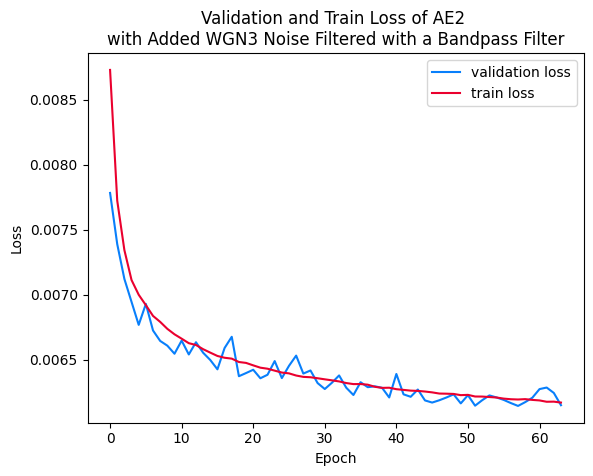

In [20]:
# VISUALISATIONS OF THE LEARNING BEHAVIOR

# Visualises the the validation and train loss of the given loss_*.csv in a single graph

# filename = 'models/ecg/loss_ecg_both_norm.csv'
# filename = 'models/motion/loss_1_10_motion.csv'
filename = 'models/wgn/loss_2_wgn3_bandpass.csv'

directory = os.path.join('results', 'training')
if not os.path.exists(directory):
    os.makedirs(directory)

df = pd.read_csv(filename)

plt.plot(df['epoch'], df['val_loss'], color='#087ffb', label='validation loss')
plt.plot(df['epoch'], df['train_loss'], color='#ea002e', label='train loss')

plt.title('Validation and Train Loss of AE2 \nwith Added WGN3 Noise Filtered with a Bandpass Filter')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.plot()
plt.savefig(os.path.join(directory, 'scg_2_wgn3_bandpass.png'), format='png', bbox_inches='tight')
plt.show()

Sample index: 20827
RMSE 
Clean/Noise:		0.29689595103263855
Clean/Predicted:	0.12123637646436691


SNR 
Clean/Noise:		-1.9249224939616074
Clean/Predicted:	-3.188856840133667
Clean/BP:		-2.8411840003889557


PCORR 
Clean/Noise:		-0.06632343156082404
Clean/Predicted:	0.4098165300015617
Clean/BP:		0.28078485873127274




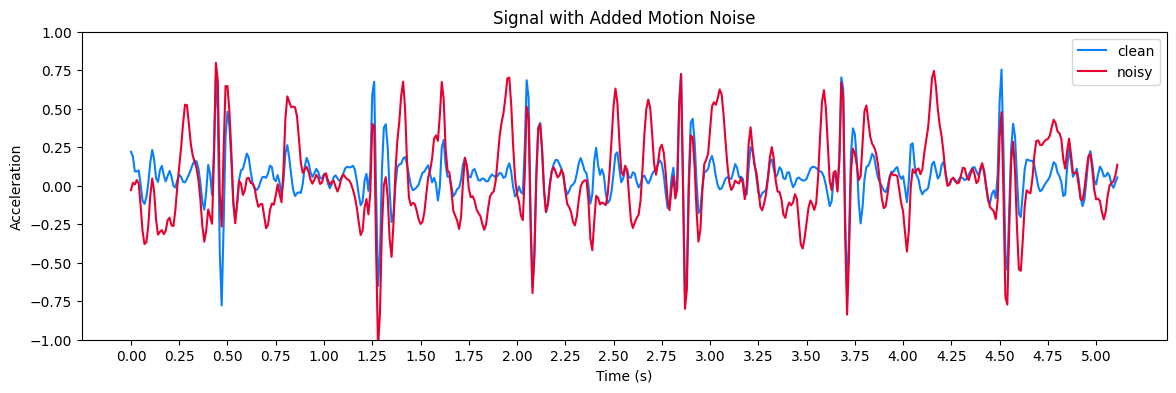

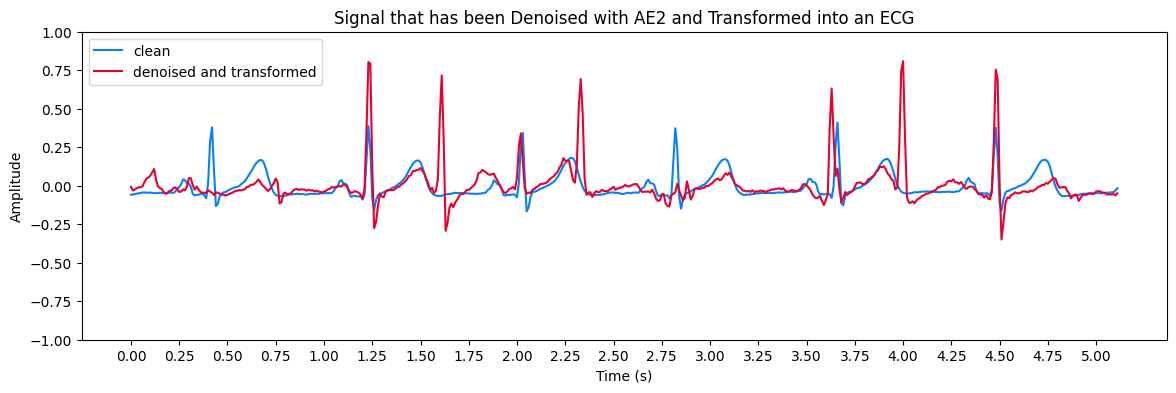

In [ ]:
# VISUALISATIONS FOR THE DENOISING PERFORMANCE AND THE NOISE MODEL

# Visualises a clean and noisy SCG signal in one graph and the clean and denoised/transformed SCG/ECG signal in another graph. 
# The signal will be selected randomly and the denoising method can be configured.

# If the SCG/ECG transformation performance with possibly noisy SCG signals should be visualised
ecg = True

# True, if wavelet denoising should be visualised 
wd = False

directory = os.path.join('results', 'denoising_viz')
if not os.path.exists(directory):
    os.makedirs(directory)

# The model for denoising. Either AE1 or AE2

# model = AE1(kernel_count=256).to(device)
# model.load_state_dict(torch.load(os.path.join(model_directory, 'wgn/m2_128_20.pth'), map_location=device))

model = AE2(kernel_count=128).to(device)
model.load_state_dict(torch.load(os.path.join(model_directory, 'motion/model_2_wgn3.pth'), map_location=device))

# AE2 as the model for SCG/ECG transformation
model_ecg = AE2(kernel_count=256).to(device)
model_ecg.load_state_dict(torch.load(os.path.join(model_directory, 'ecg/model_ecg_scg_norm.pth'), map_location=device))

model.eval()
model_ecg.eval()

with torch.no_grad():
    
    # Randomly select a sample from the test dataset.
    i = random.choice(range(0, len(test_dataset)))
    # i = 13498 # WGN
    # i = 11652 # Motion
    i = 20827 # ECG
    print(f'Sample index: {i}')

    noise, clean = test_dataset[i]

    if ecg:
        # Only add noise here so that the SNR can be calculated
        clean_scg = noise.numpy()
        noise = test_dataset.dataset._add_motion(clean_scg) # TODO Maybe normalize
        snr_ecg = snr(clean_scg, noise)
        noise = torch.from_numpy(noise.values)

    # Denoise with either WD or the respective AE and predict the ECG from the results
    if wd:
        predicted = denoise_wavelet(noise.numpy(), method='BayesShrink', mode='soft', wavelet_levels=1, wavelet='sym8', rescale_sigma='True')
        predicted = denormalise(predicted, test_dataset.dataset.min_val, test_dataset.dataset.max_val)
        predicted = torch.from_numpy(predicted).reshape(-1, 1, window_size).to(device, dtype=torch.float)

    clean, noise = clean.reshape(-1, 1, window_size).to(device, dtype=torch.float), noise.reshape(-1, 1, window_size).to(device, dtype=torch.float)

    if not wd:
        predicted = model(noise)
    predicted_ecg = model_ecg(predicted)

    predicted = predicted.to('cpu').reshape(window_size).numpy()
    predicted_ecg = predicted_ecg.to('cpu').reshape(window_size).numpy()
    clean = clean.to('cpu').reshape(window_size).numpy()
    noise = noise.to('cpu').reshape(window_size).numpy()

    # Denormalise the noisy data to calculate the SNR and use it and the denoised SCG for visualisation when not currently in the ECG mode. 
    # Use the normalised noise data and the predicted ECG otherwise.
    noise_snr = noise if ecg else denormalise(noise, test_dataset.dataset.min_val, test_dataset.dataset.max_val)
    predicted = predicted_ecg if ecg else predicted

    print(f'RMSE \nClean/Noise:\t\t{rmse(clean, noise)}\nClean/Predicted:\t{rmse(clean, predicted)}\n\n')
    print(f'SNR \nClean/Noise:\t\t{snr_ecg if ecg else snr(clean, noise_snr)}\nClean/Predicted:\t{snr(clean, predicted)}\nClean/BP:\t\t{snr(clean, bandpass(predicted, order=4, fs=100.0, lowcut=5.0, highcut=30.0))}\n\n')
    print(f'PCORR \nClean/Noise:\t\t{pcorr(clean, noise)}\nClean/Predicted:\t{pcorr(clean, predicted)}\nClean/BP:\t\t{pcorr(clean, bandpass(predicted, order=4, fs=100.0, lowcut=5.0, highcut=30.0))}\n\n')
    
    # The sample range that should be visualised
    sample_from = 0
    time_to = 512

    # Clean/Noise Graph
    plt.figure(figsize=(14, 4))

    x = np.array(range(time_to)[sample_from:time_to]) / sampling_rate
    plt.plot(x, clean_scg[sample_from:time_to] if ecg else clean[sample_from:time_to], color='#087ffb', label='clean')
    plt.plot(x, noise_snr[sample_from:time_to], color='#ea002e', label='noisy')
    plt.xticks(x[::25])
    
    plt.title('Signal with Added Motion Noise')
    plt.xlabel('Time (s)')
    plt.ylabel(r'Acceleration')
    plt.ylim(bottom=-1, top=1)
    plt.legend()

    plt.plot()
    plt.savefig(os.path.join(directory, 'noise_ecg.png'), format='png', bbox_inches='tight')
    plt.show()


    # Clean/Denoised Graph
    plt.figure(figsize=(14, 4))

    x = np.array(range(time_to)[sample_from:time_to]) / sampling_rate
    plt.plot(x, clean[sample_from:time_to], color='#087ffb', label='clean')
    plt.plot(x, predicted[sample_from:time_to], color='#ea002e', label='denoised and transformed')
    plt.xticks(x[::25])
    
    plt.title('Signal that has been Denoised with AE2 and Transformed into an ECG')
    plt.xlabel('Time (s)')
    plt.ylabel(r'Amplitude')
    plt.ylim(bottom=-1, top=1)
    plt.legend()

    plt.plot()
    plt.savefig(os.path.join(directory, 'denoising_ecg.png'), format='png', bbox_inches='tight')
    plt.show()

In [ ]:
# COMPARISON OF DIFFERENT DENOISING METHODS

# Gives the  percentage change of the two specified labels (`label_1` and `label_2`) from the config of the respective `results.json`
# for specific scopes and a specific metric (mean or sd)

# The filename for the respective results
filename = 'results/2/wgn/results.json'

label_1 = 'WD' # The first label from the results
label_2 = 'AE2' # The second label from the results
scopes = ['all'] # The scope of SNRs
metric = 'mean' # The the metric to be shown (mean or sd)
# 'labels': ['Training Data', 'Results', 'Training Data + Results', 'No Usage'],

with open(filename) as json_file:
    results = json.load(json_file)

    for scope in scopes:
        print(f'Scope: {scope}')
        print('\033[1m{:^8} {:^8} {:^8} {:^8}\033[0m'.format('Evaluation', label_1, label_2, 'Percentage Change'))
        for evaluation in results[label_1][scope]:
            val = results[label_1][scope][evaluation][metric]
            val_cmp = results[label_2][scope][evaluation][metric]
            
            percentage_change = (val_cmp - val) / val * 100
            print(f'{evaluation:>8}: {val:>8.5f} {val_cmp:>8.5f} {percentage_change:>8.2f} %')

Scope: all
Evaluation    WD      AE2    Percentual Change
  result:  0.01720  0.01951    13.40 %
 snr_imp:  2.56132  3.83880    49.88 %
     mse:  0.00811  0.00563   -30.64 %
    rmse:  0.07776  0.06392   -17.80 %
     mae:  0.06002  0.04770   -20.52 %
   xcorr:  0.00078  0.00086     9.90 %
   pcorr:  0.79885  0.86125     7.81 %
     prd: 57.24793 49.78099   -13.04 %
cpu_time:  0.00062  0.01023  1545.00 %


In [ ]:
# GENERATION OF (LaTeX) TABLES FROM THE RESULTS

# The table displays the evaluation methods in the columns and the methods and target_snr values in the rows.
# With the exception of the last experiment, all evaluation metrics (SNR improvement, RMSE, pcorr and CPU time) are displayed. 
# For the last experiment only the pcorr and RMSE are displayed. 

# The path to the respective results file
filename = 'results/0/results.json'
results = json.load(open(filename))

# The respective target_snr values from the config of the results file that should appear in the table
# target_snr_print = ['ECG Noise', 'ECG Predicted']
# target_snr_print = ['all']
target_snr_print = ['-1', '0', '2', '5', '7', 'all']

last_exp = target_snr_print == ['ECG Noise', 'ECG Predicted']

header = [[method, scope]  for method in results.keys() for scope in target_snr_print]
column_names = pd.DataFrame(header, columns=['Method', ''])

rows = [[], [], [], []]
for method, scope in header:
        rows[0].append(f"${results[method][scope]['snr_imp']['mean']:.2f} \pm {results[method][scope]['snr_imp']['sd']:.2f}$")
        rows[1].append(f"${results[method][scope]['rmse']['mean']:.2f} \pm {results[method][scope]['rmse']['sd']:.2f}$")
        rows[2].append(f"${results[method][scope]['pcorr']['mean']:.2f} \pm {results[method][scope]['pcorr']['sd']:.2f}$")
        rows[3].append(f"${results[method][scope]['cpu_time']['mean']*1000:.2f} \pm {results[method][scope]['cpu_time']['sd']*1000:.2f}$")

if last_exp:
        rows = rows[1:3] # Show only pcorr and RMSE for last experiment

columns = pd.MultiIndex.from_frame(column_names)
index = ['RMSE', 'pcorr'] if last_exp else ['$SNR_{imp}$', 'RMSE', 'pcorr', 'CPU Time (ms)'] 

df = pd.DataFrame(rows, columns=columns, index=index)
df = df.T # Transpose the dataframe so that the evaluation methods are in the columns and the methods and target_snr values in the rows.
display(df)

# Print LaTeX code
print(df.style.to_latex(clines='skip-last;data', multirow_align='c', sparse_columns=True, sparse_index=True, hrules=True))

$SNR_{imp}$             RMSE  \
Method                                                           
Training Data           -1    $4.60 \pm 1.64$  $0.09 \pm 0.05$   
                        0     $4.26 \pm 1.74$  $0.08 \pm 0.05$   
                        2     $3.26 \pm 1.92$  $0.07 \pm 0.04$   
                        5     $1.53 \pm 2.17$  $0.06 \pm 0.04$   
                        7     $0.07 \pm 2.38$  $0.06 \pm 0.04$   
                        all   $2.74 \pm 2.62$  $0.07 \pm 0.05$   
Results                 -1    $4.99 \pm 1.53$  $0.09 \pm 0.06$   
                        0     $4.57 \pm 1.62$  $0.08 \pm 0.06$   
                        2     $3.29 \pm 1.85$  $0.08 \pm 0.05$   
                        5     $1.33 \pm 2.21$  $0.07 \pm 0.05$   
                        7    $-0.22 \pm 2.45$  $0.07 \pm 0.05$   
                        all   $2.79 \pm 2.78$  $0.08 \pm 0.05$   
Training Data + Results -1    $4.78 \pm 1.49$  $0.09 \pm 0.06$   
                        0     $4.40 \pm 1.59$  $0.09 \pm 0.06$   
                        2     $3.21 \pm 1.82$  $0.08 \pm 0.05$   
                        5     $1.28 \pm 2.17$  $0.07 \pm 0.05$   
                        7    $-0.30 \pm 2.35$  $0.07 \pm 0.05$   
                        all   $2.67 \pm 2.71$  $0.08 \pm 0.05$   
No Usage                -1    $5.54 \pm 1.65$  $0.08 \pm 0.04$   
                        0     $5.23 \pm 1.77$  $0.07 \pm 0.04$   
                        2     $4.31 \pm 2.02$  $0.06 \pm 0.04$   
                        5     $2.70 \pm 2.36$  $0.05 \pm 0.03$   
                        7     $1.41 \pm 2.66$  $0.05 \pm 0.03$   
                        all   $3.84 \pm 2.64$  $0.06 \pm 0.04$   

                                       pcorr     CPU Time (ms)  
Method                                                          
Training Data           -1   $0.80 \pm 0.07$  $25.38 \pm 5.74$  
                        0    $0.82 \pm 0.07$  $25.38 \pm 5.54$  
                        2    $0.86 \pm 0.06$  $25.36 \pm 5.28$  
                        5    $0.90 \pm 0.05$  $25.30 \pm 5.91$  
                        7    $0.91 \pm 0.05$  $25.27 \pm 5.10$  
                        all  $0.86 \pm 0.07$  $25.34 \pm 5.59$  
Results                 -1   $0.81 \pm 0.07$  $25.65 \pm 4.57$  
                        0    $0.83 \pm 0.07$  $25.63 \pm 4.82$  
                        2    $0.87 \pm 0.06$  $25.74 \pm 5.00$  
                        5    $0.91 \pm 0.05$  $25.60 \pm 5.07$  
                        7    $0.92 \pm 0.05$  $25.68 \pm 4.68$  
                        all  $0.87 \pm 0.08$  $25.66 \pm 4.84$  
Training Data + Results -1   $0.81 \pm 0.07$  $30.96 \pm 5.63$  
                        0    $0.83 \pm 0.07$  $30.97 \pm 5.71$  
                        2    $0.87 \pm 0.06$  $30.96 \pm 5.23$  
                        5    $0.91 \pm 0.05$  $30.95 \pm 6.16$  
                        7    $0.92 \pm 0.05$  $30.97 \pm 5.52$  
                        all  $0.87 \pm 0.07$  $30.95 \pm 5.69$  
No Usage                -1   $0.80 \pm 0.08$   $8.84 \pm 6.00$  
                        0    $0.82 \pm 0.07$   $8.96 \pm 5.98$  
                        2    $0.86 \pm 0.06$   $8.82 \pm 6.00$  
                        5    $0.90 \pm 0.05$   $8.86 \pm 6.19$  
                        7    $0.92 \pm 0.05$   $9.03 \pm 5.97$  
                        all  $0.86 \pm 0.08$   $8.91 \pm 6.03$

\begin{tabular}{llllll}
\toprule
 &  & $SNR_{imp}$ & RMSE & pcorr & CPU Time (ms) \\
Method &  &  &  &  &  \\
\midrule
\multirow[c]{6}{*}{Training Data} & -1 & $4.60 \pm 1.64$ & $0.09 \pm 0.05$ & $0.80 \pm 0.07$ & $25.38 \pm 5.74$ \\
 & 0 & $4.26 \pm 1.74$ & $0.08 \pm 0.05$ & $0.82 \pm 0.07$ & $25.38 \pm 5.54$ \\
 & 2 & $3.26 \pm 1.92$ & $0.07 \pm 0.04$ & $0.86 \pm 0.06$ & $25.36 \pm 5.28$ \\
 & 5 & $1.53 \pm 2.17$ & $0.06 \pm 0.04$ & $0.90 \pm 0.05$ & $25.30 \pm 5.91$ \\
 & 7 & $0.07 \pm 2.38$ & $0.06 \pm 0.04$ & $0.91 \pm 0.05$ & $25.27 \pm 5.10$ \\
 & all & $2.74 \pm 2.62$ & $0.07 \pm 0.05$ & $0.86 \pm 0.07$ & $25.34 \pm 5.59$ \\
\cline{1-6}
\multirow[c]{6}{*}{Results} & -1 & $4.99 \pm 1.53$ & $0.09 \pm 0.06$ & $0.81 \pm 0.07$ & $25.65 \pm 4.57$ \\
 & 0 & $4.57 \pm 1.62$ & $0.08 \pm 0.06$ & $0.83 \pm 0.07$ & $25.63 \pm 4.82$ \\
 & 2 & $3.29 \pm 1.85$ & $0.08 \pm 0.05$ & $0.87 \pm 0.06$ & $25.74 \pm 5.00$ \\
 & 5 & $1.33 \pm 2.21$ & $0.07 \pm 0.05$ & $0.91 \pm 0.05$ & $25.60 \pm 5.07

Sample index: 819
Target SNR: 15
Acheived SNR: 15.19257713304308


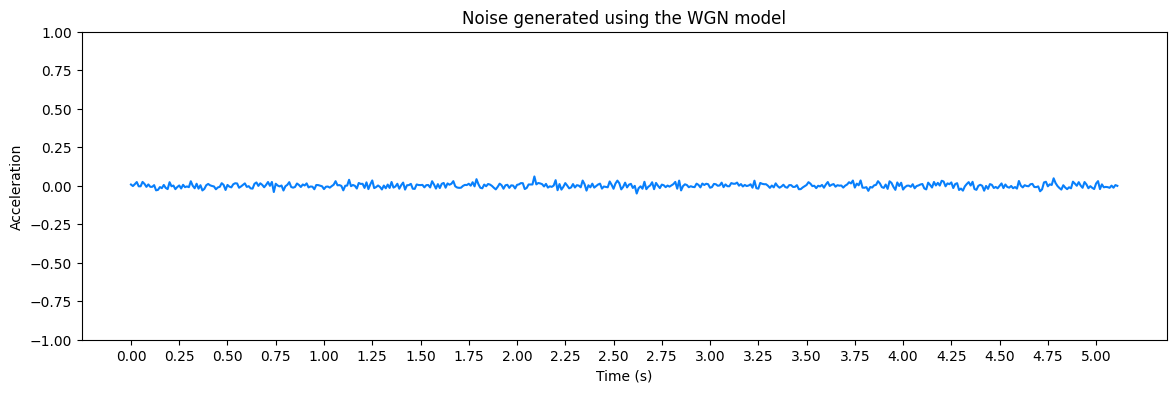

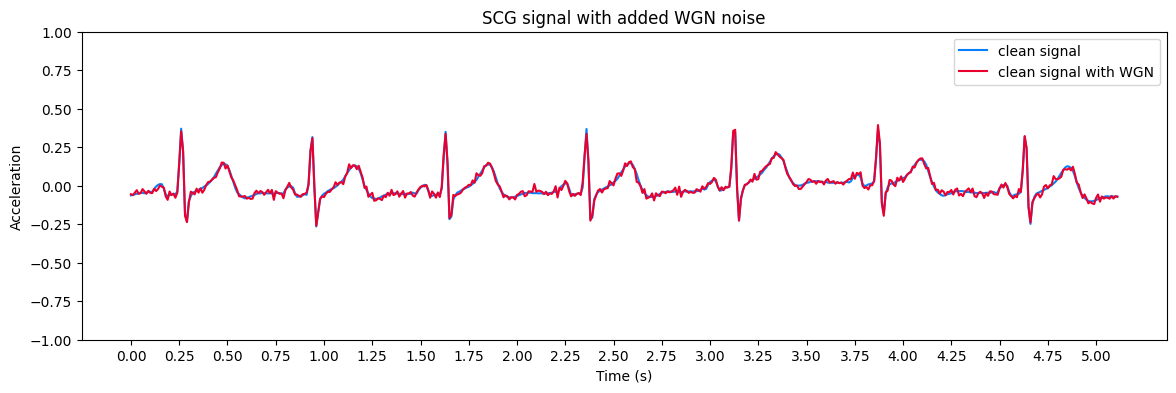

In [ ]:
# VISUALISATION FOR WGN NOISE

# Prints a figure with only the noise and a figure with the added noise to the signal together with the clean signal itself

directory = os.path.join('results', 'noise_viz')
if not os.path.exists(directory):
    os.makedirs(directory)

# Select a random sample from the test dataset
i = random.choice(range(0, len(test_dataset)))
print(f'Sample index: {i}')

_, data = test_dataset[i]

data = data.numpy()

# Generate WGN noise with the specified target_snr
target_snr = 15
print(f'Target SNR: {target_snr}')

data_avg_watts = np.mean(data ** 2)
data_avg_db = 10 * np.log10(data_avg_watts)

noise_avg_db = data_avg_db - target_snr
noise_avg_watts = 10 ** (noise_avg_db / 10)

mean_noise = 0
noise = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(data))
data_noise = data + noise
print(f'Acheived SNR: {snr(data, data_noise)}')

# The sample range that should be visualised
time_from = 0
time_to = 512 

plt.figure(figsize=(14, 4))

x = np.array(range(time_to)[time_from:time_to]) / sampling_rate
plt.plot(x, noise[time_from:time_to], color='#087ffb')
plt.xticks(x[::25])

plt.title('Noise generated using the WGN model')
plt.xlabel('Time (s)')
plt.ylabel(r'Acceleration')
plt.ylim(bottom=-1, top=1)

plt.savefig(os.path.join(directory, 'noise_wgn.png'), format='png', bbox_inches='tight')
plt.show()


plt.figure(figsize=(14, 4))

x = np.array(range(time_to)[time_from:time_to]) / sampling_rate
plt.plot(x, data[time_from:time_to], color='#087ffb', label='clean signal')
plt.plot(x, data_noise[time_from:time_to], color='#ea002e', label='clean signal with WGN')
plt.xticks(x[::25])

plt.title('SCG signal with added WGN noise')
plt.xlabel('Time (s)')
plt.ylabel(r'Acceleration')
plt.ylim(bottom=-1, top=1)

plt.legend()
plt.show()

Sample index: 2279


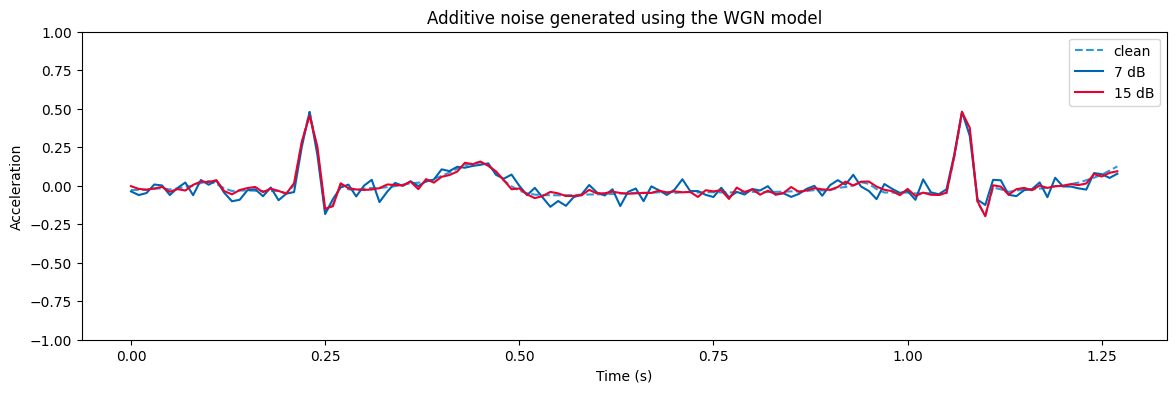

In [ ]:
# VISUALISATION FOR MULTIPLE WGN NOISE SAMPLES

# Prints a figure with multiple samples of added noise to the clean signal together with the clean signal itself

directory = os.path.join('results', 'noise_viz')
if not os.path.exists(directory):
    os.makedirs(directory)
    
color_map = ['#2c9bda', '#0065b0', '#ea002e']

# Select a random sample from the test dataset
i = random.choice(range(0, len(test_dataset)))
i = 2279
print(f'Sample index: {i}')

_, data = test_dataset[i]

data = data.numpy()

# Generate WGN noise for the specified target_snrs
target_snrs = [7, 15]
noise = []

mean_noise = 0

data_avg_watts = np.mean(data ** 2)
data_avg_db = 10 * np.log10(data_avg_watts)

# Create the noise for the specified target_snrs
for target_snr in target_snrs:
    noise_avg_db = data_avg_db - target_snr
    noise_avg_watts = 10 ** (noise_avg_db / 10)
    noise.append(np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(data)))

# The sample range that should be visualised
time_from = 0
time_to = 128

plt.figure(figsize=(14, 4))
x = np.array(range(time_to)[time_from:time_to]) / sampling_rate

# Plot the clean signal
plt.plot(x, data[time_from:time_to], label='clean', color=color_map[0], linestyle='dashed')

# Plot the clean signals with added noise for every noise sample from the `noise` array
for i, noise_record in enumerate(noise):
    data_noise = data + noise_record
    plt.plot(x, data_noise[time_from:time_to], label=f'{target_snrs[i]} dB', color=color_map[i+1])

plt.xticks(x[::25])

plt.title('Additive noise generated using the WGN model')
plt.xlabel('Time (s)')
plt.ylabel(r'Acceleration')
plt.ylim(bottom=-1, top=1)
plt.legend()

plt.savefig(os.path.join(directory, 'noise_multi.png'), format='png', bbox_inches='tight')
plt.show()

Sample index: 6515
686709
Noise index: 215977


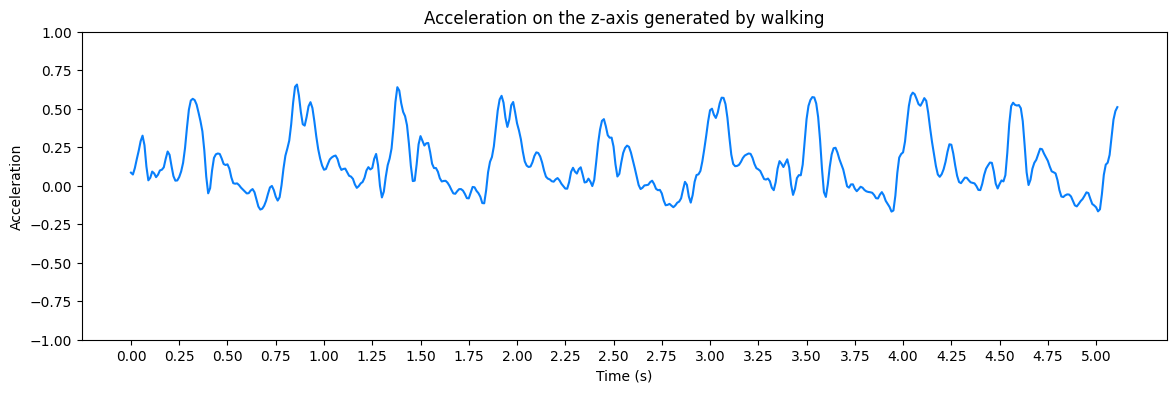

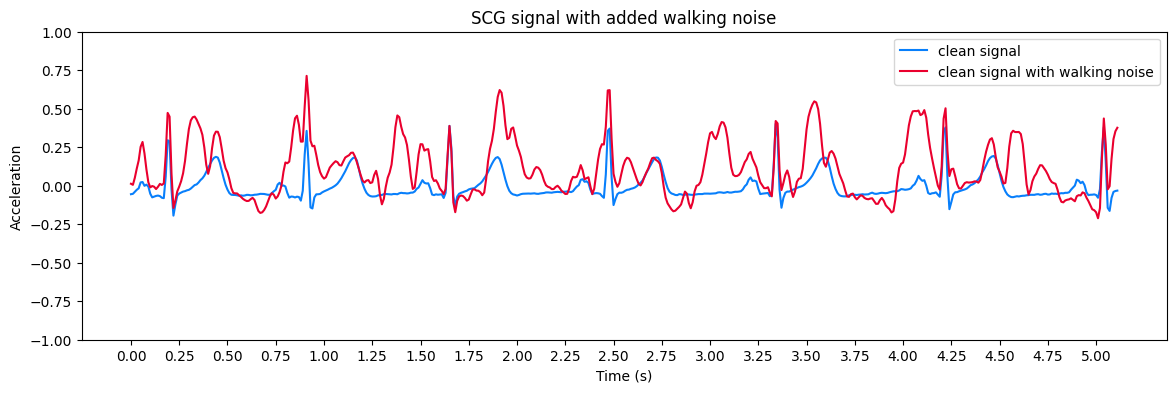

In [ ]:
# VISUALISATIONS FOR MOTION NOISE

# Prints one figure with only the generated noise and one with the added noise on a random clean SCG sample together with this clean sample itself

directory = os.path.join('results', 'noise_viz')
if not os.path.exists(directory):
    os.makedirs(directory)

# Select a random sample from the test dataset
i = random.choice(range(0, len(test_dataset)))
i = 6515
print(f'Sample index: {i}')

_, data = test_dataset[i]

# Randomly select `len(data)` consecutive samples from the processed noise dataset.
num_samples = len(data)
rows = range(test_dataset.dataset.data_motion_noise.shape[0])
index_start = random.randint(rows.start, rows.stop - num_samples)
index_start = 215977
print(f'Noise index: {index_start}')

noise = test_dataset.dataset.data_motion_noise.iloc[index_start:index_start + num_samples]

# Only add 80 % of noise to the data.
noise_data = data + 0.8 * noise

# The sample range that should be visualised
time_from = 0
time_to = 512 

# Figure with only the noise
plt.figure(figsize=(14, 4))

x = np.array(range(time_to)[time_from:time_to]) / sampling_rate
plt.plot(x, noise.iloc[time_from:time_to], color='#087ffb')
plt.xticks(x[::25])

plt.title('Acceleration on the z-axis generated by walking')
plt.xlabel('Time (s)')
plt.ylabel(r'Acceleration')
plt.ylim(bottom=-1, top=1)

plt.savefig(os.path.join(directory, 'noise_walking.png'), format='png', bbox_inches='tight')
plt.show()


# Figure with the added noise to the clean signal and the clean signal itself
plt.figure(figsize=(14, 4))

x = np.array(range(time_to)[time_from:time_to]) / sampling_rate
plt.plot(x, data[time_from:time_to], color='#087ffb', label='clean signal')
plt.plot(x, noise_data.iloc[time_from:time_to], color='#ea002e', label='clean signal with walking noise')
plt.xticks(x[::25])

plt.title('SCG signal with added walking noise')
plt.xlabel('Time (s)')
plt.ylabel(r'Acceleration')
plt.ylim(bottom=-1, top=1)

plt.legend()

plt.savefig(os.path.join(directory, 'noise_added_walking.png'), format='png', bbox_inches='tight')
plt.show()